## Goal: To generate five new features for the modeling
1. Accuracy on every bundle
2. Accuracy on each part
3. Accuracy on the count of tags
4. Accuracy on the every tag
4. Cumulative user accuracy using exponentially weighted mean

In [1]:
# To ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Import the libraries to handle the np array, pandas dataframe, and visualiztion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import libaries to monitor the process and time
import psutil
from tqdm import tqdm

In [2]:
# Print the memory use
psutil.virtual_memory().percent

68.1

### Pre-define optimal data types of the columns

In [3]:
%%time

# Read the train.csv dataset

# Define the data types
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16", 
    "content_type_id": "boolean", 
    "task_container_id": "int16",
    "user_answer": "int8", 
    "answered_correctly": "int8", 
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"    
}

# Import the train, validate, and test dataset of 2000 users
df_train = pd.read_csv("data_2000users/train.csv", dtype=dtypes)
df_validate = pd.read_csv("data_2000users/validate.csv", dtype=dtypes)
df_test = pd.read_csv("data_2000users/test.csv", dtype=dtypes)

# Print the memory use
print("Momery usage after import train/validate/test files: ", psutil.virtual_memory().percent)

# Read the questions.csv
df_ques = pd.read_csv("questions_with_tag_counts.csv", index_col=0)

# Read the lectures.csv
df_lecs = pd.read_csv("lectures_with_part_name.csv", index_col=0)

# Print the memory use
print("Momoery usage after import other file: ", psutil.virtual_memory().percent)

# Print the number of rows and columns in all datasets
print("(# rows, # cols) of train: ", df_train.shape)
print("(# rows, # cols) of validate: ", df_validate.shape)
print("(# rows, # cols) of test: ", df_test.shape)
print("(# rows, # cols) of question_with_tag_counts.csv: ", df_ques.shape)
print("(# rows, # cols) of lectures_with_part_name.csv: ", df_lecs.shape)

Momoery usage after import train/validate/test files:  68.4
Momoery usage after import other file:  68.4
(# rows, # cols) of train:  (411517, 18)
(# rows, # cols) of validate:  (50842, 18)
(# rows, # cols) of test:  (52868, 18)
(# rows, # cols) of question_with_tag_counts.csv:  (13523, 6)
(# rows, # cols) of lectures_with_part_name.csv:  (418, 5)
CPU times: user 1.32 s, sys: 121 ms, total: 1.44 s
Wall time: 1.47 s


### Preapre for feature engineering
1. Handle missing values in columns prior_question_had_explanation and prior_question_elapsed_time
2. Handle the np.inf values in column prior_question_elapsed_time
3. Drop the lecture rows
4. Merge train with df_ques and df_lecs

In [4]:
# Drop the columns merged from questions.csv and lectures.csv downloaded from Kaggle

cols = ['lecture_id', 'tag', 'lecture_part', 'type_of', 'question_id',
        'bundle_id', 'correct_answer', 'question_part', 'tags']

df_train = df_train.drop(columns = cols)
df_validate = df_validate.drop(columns = cols)
df_test = df_test.drop(columns = cols)

# Print the shapes
df_train.shape, df_validate.shape, df_test.shape

((411517, 9), (50842, 9), (52868, 9))

In [5]:
# Define the function about how to fill the missing values
# in columns: prior_question_had_explanation, prior_question_elapsed_time

def handle_null(df):
    '''
    This function is going to fill the missing values 
    in the column prior_question_elapsed_time with False (boolean) 
    and fill the missing values in the column prior_question_elapsed_time
    with 0.
    '''
    df.prior_question_had_explanation.fillna(False, inplace = True)
    df.prior_question_elapsed_time.fillna(False, inplace = True)
    return df

In [6]:
# Test the function using train
handle_null(df_train)

# Print the missing values in the train
df_train.isnull().sum(axis=0)

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [7]:
# Apply the function to df_validate and df_test

validate = handle_null(df_validate)
test = handle_null(df_test)

# Print the missing values in the df_test
df_test.isnull().sum(axis=0)

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [8]:
# Define a function to handle the np.inf

def handle_inf(df):
    m = df.prior_question_elapsed_time.apply(lambda i: 0 if i == np.inf else i)
    df.prior_question_elapsed_time = m
    return df

In [9]:
# Print the first 2 row of the train
df_train.head(2)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,1864702,5720,False,0,1,1,False,False
1,45951,1864702,5204,False,1,1,0,inf,False


In [11]:
# Test the function on train
train = handle_inf(df_train)
train.head(2)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,1864702,5720,False,0,1,1,False,False
1,45951,1864702,5204,False,1,1,0,0,False


In [12]:
# Apply the function on validate and test

validate = handle_inf(validate)
test = handle_inf(test)

In [13]:
# Define a function to drop the lecture rows

def drop_lecture_rows(df):
    '''
    Drop the lecture rows in the dataframe
    '''
    mask = df['answered_correctly'] != -1
    df = df[mask]
    return df

In [14]:
# Test the function on df_train

print("Shape of train dataset before dropping the rows: ", df_train.shape)
train = drop_lecture_rows(df_train)
print("Shape of train dataset after dropping the rows: ", train.shape)

Shape of train dataset before dropping the rows:  (411517, 9)
Shape of train dataset after dropping the rows:  (403377, 9)


In [15]:
# Apply the fucntion on df_validate and df_test

print("Shape of validate dataset before dropping the rows: ", df_validate.shape)
validate = drop_lecture_rows(df_validate)
print("Shape of validate dataset after dropping the rows: ", validate.shape)

print("Shape of test dataset before dropping the rows: ", df_test.shape)
test = drop_lecture_rows(df_test)
print("Shape of test dataset after dropping the rows: ", test.shape)

Shape of validate dataset before dropping the rows:  (50842, 9)
Shape of validate dataset after dropping the rows:  (49945, 9)
Shape of test dataset before dropping the rows:  (52868, 9)
Shape of test dataset after dropping the rows:  (51971, 9)


In [16]:
# Print the first 2 rows in questions dataframe
df_ques.head(2)

,question_id,bundle_id,correct_answer,part,tags,tag_count
0,0,0,0,1,51 131 162 38,4
1,1,1,1,1,131 36 81,3


In [17]:
# Print the first 2 rows in lectures table
df_lecs.head(2)

,lecture_id,tag,part,type_of,part_content
0,89,159,5,concept,Incomplete Sentences
1,100,70,1,concept,Photographs


**Takeaways**
1. Because the lecture rows have been dropped in the train,validate, and test for the purpose of modeling, there is no need to join the lectures table. 

In [18]:
# Concat the train with questions_with_tag_counts.csv
train = train.merge(df_ques, how='left', left_on='content_id', right_on='question_id')

# Print the shape of the merged dataset
print(train.shape)

# Print the first 5 rows
train.head()

(403377, 15)


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags,tag_count
0,0,1864702,5720,False,0,1,1,False,False,5720,5720,1,5,115,1
1,45951,1864702,5204,False,1,1,0,0,False,5204,5204,3,5,173,1
2,74342,1864702,4094,False,2,1,1,43000,False,4094,4094,1,5,1,1
3,96778,1864702,9699,False,3,0,1,25000,False,9699,9699,0,5,55,1
4,132969,1864702,5889,False,4,2,0,19000,False,5889,5889,3,5,89,1


In [33]:
# Any null values produced during the merge?
train.isnull().sum(axis=0)

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
tag_count                         0
dtype: int64

**After the lecture rows are dropped, in the merged train dataset**
1. The content id is the same as the question id. 
2. No missing values exist. 

### Create Four New Features
1. Accuracy on every bundle
2. Accuracy on each part
3. Accuracy on the count of tags
4. Accuracy on the every tag
4. Cumulative user accuracy using exponentially weighted mean

In [56]:
train.sample(5)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags,tag_count
193058,852047505,1003355491,3075,False,227,0,1,30340,True,3075,3075,0,4,74 183 92,3
30879,352377070,81880241,5356,False,8,3,1,8000,True,5356,5356,3,5,55,1
81444,19075747542,336720047,648,False,2482,1,1,18000,True,648,648,1,2,90 100 81 29,4
400373,664009,2132212188,6878,False,14,0,0,51000,False,6878,6877,1,6,65,1
47282,1595813131,162204275,5660,False,286,2,0,0,True,5660,5660,3,5,4,1


#### Accuracy on Every Bundle

In [57]:
# Is the bundle_id is the same as question_id
(train.question_id == train.bundle_id).sum() # No

306754

In [49]:
# Compute the accuracy for every bundle id

bundle_stats = train.groupby('bundle_id').answered_correctly.agg(['mean', 'count', 'std', 'median', 'skew'])

bundle_stats.columns = ['mean_bundle_accuracy', 'num_questions', 'std_bundle_accuracy', 
                        'median_bundle_accuracy', 'skew_bundle_accuracy']

bundle_stats.head()

,mean_bundle_accuracy,num_questions,std_bundle_accuracy,median_bundle_accuracy,skew_bundle_accuracy
bundle_id,,,,,
0,0.888889,45,0.317821,1.0,-2.561045
1,0.857143,35,0.355036,1.0,-2.133801
2,0.559809,209,0.497602,1.0,-0.242710
3,0.732673,101,0.444772,1.0,-1.067396
4,0.605263,152,0.490410,1.0,-0.435010


In [50]:
# # Sava as the bundle_stats.csv
# bundle_stats.to_csv(r'data_2000users/bundle_stats.csv')

#### Accuracy on Every Part

In [38]:
# How many unique tag numbers in the df?
df.part.nunique() 

7

In [51]:
# Compute the accuracy on eveary part

part_stats = train.groupby('part').answered_correctly.agg(['mean', 'count', 'std', 'median', 'skew'])

part_stats.columns = ['mean_part_accuracy', 'num_question', 'std_part_accuracy', 
                      'median_part_accuracy', 'skew_part_accuracy']

part_stats

,mean_part_accuracy,num_question,std_part_accuracy,median_part_accuracy,skew_part_accuracy
part,,,,,
1,0.740719,32270,0.438247,1,-1.098622
2,0.697932,70759,0.459158,1,-0.862179
3,0.679698,37933,0.466599,1,-0.770289
4,0.616874,35380,0.486155,1,-0.480836
5,0.610488,163705,0.487641,1,-0.453160
6,0.652369,43037,0.476224,1,-0.639934
7,0.673089,20293,0.469096,1,-0.738042


In [52]:
# # Sava as the part_stats.csv
# part_stats.to_csv(r'data_2000users/part_stats.csv')

#### Accuracy on the count of tags

In [44]:
# How many unique count of the tags for each question
df.tag_count.nunique() 

6

In [53]:
# Compute the accuracy on eveary part

tagcount_stats = train.groupby('tag_count').answered_correctly.agg(['mean', 'count', 'std', 'median', 'skew'])

tagcount_stats.columns = ['mean_tagcount_accuracy', 'num_questions', 'std_tagcount_accuracy', 
                          'median_tagcount_accuracy', 'skew_tagcount_accuracy']

tagcount_stats

,mean_tagcount_accuracy,num_questions,std_tagcount_accuracy,median_tagcount_accuracy,skew_tagcount_accuracy
tag_count,,,,,
1,0.615325,193821,0.486520,1,-0.474089
2,0.677716,12942,0.467369,1,-0.760613
3,0.667953,91767,0.470950,1,-0.713265
4,0.691331,66547,0.461948,1,-0.828391
5,0.705149,34431,0.455982,1,-0.899866
6,0.764022,3869,0.424664,1,-1.244083


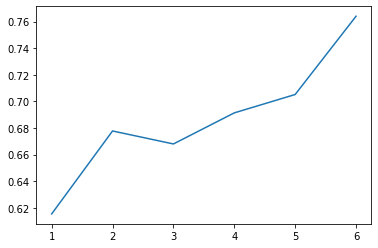

In [48]:
x = [1,2,3,4,5,6]
y = tagcount_stats.mean_tagcount_accuracy
plt.plot(x, y)
plt.show()

In [54]:
# # Sava as the part_stats.csv
# tagcount_stats.to_csv(r'data_2000users/tagcount_stats.csv')

#### Accuray on question-tags

In [58]:
# Count how many unique question-tags in the dataset
train.tags.nunique()

1485

In [59]:
# Compute the accuracy on eveary part

tag_stats = train.groupby('tags').answered_correctly.agg(['mean', 'count', 'std', 'median', 'skew'])

tag_stats.columns = ['mean_tags_accuracy', 'num_questions', 'std_tags_accuracy', 
                     'median_tags_accuracy', 'skew_tags_accuracy']

tag_stats.head()

,mean_tags_accuracy,num_questions,std_tags_accuracy,median_tags_accuracy,skew_tags_accuracy
tags,,,,,
1,0.600555,9015,0.489812,1.0,-0.410676
1 162,0.618574,603,0.486140,1.0,-0.489441
10 111 92,0.703704,27,0.465322,1.0,-0.945583
10 164 102,0.787500,80,0.411658,1.0,-1.432607
10 164 162 29,0.937500,48,0.244623,1.0,-3.732451


In [60]:
# # Sava as the part_stats.csv
# tag_stats.to_csv(r'data_2000users/tag_stats.csv')

#### How does accuracy changes over time for one user? 